In [189]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data
from utils.preprocessing import preprocess_data
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
SEED = 0
EPS = 1e-6

TRAIN_PROPORTION = 0.9
PAST_GDPS = None # e.g. range(1, 3) or [1, 2]
MODE = None # None | "pct" | "diff"

In [191]:
data, all_gdps = load_data()

print(f"Data shape: {data.shape}")

number_train = np.floor(data.shape[0] * TRAIN_PROPORTION).astype(int)

X_train, y_train, X_valid, y_valid, country_train, country_valid, y_mean, y_std = preprocess_data(data=data, epsilon=EPS, number_train=number_train, mode=MODE, all_gdps=all_gdps, past_gdp_lags=PAST_GDPS)

X_train[country_train == "Switzerland"].head()

Data shape: (550, 98)
Dropped 1 rows because of missing lagged GDP values
X_train shape : (495, 103)
X_valid shape : (54, 103)
y_train shape : (495,)
y_valid shape : (54,)


,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,International_Financial_Reporting_Standards_average,Employment_average,GDP_lag_1,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
4,-1.775380,2.941622,-2.394952,-1.686473,1.479051,-1.305010,1.592970,-0.610491,2.601827,-3.412154,...,-1.740805,0.894112,-0.602197,-0.415494,-0.415494,-0.363943,-0.415494,2.401897,-0.415494,-0.41215
11,-1.726786,0.519698,-2.394952,-1.686473,1.479051,-1.130083,-0.724366,-0.610491,1.585328,-0.226943,...,2.318285,0.968092,-0.562786,-0.415494,-0.415494,-0.363943,-0.415494,2.401897,-0.415494,-0.41215
16,-1.678193,-0.112108,-2.394952,-1.686473,1.286207,-0.955157,-0.724366,-0.610491,1.902984,-1.236888,...,2.291043,0.894112,-0.520744,-0.415494,-0.415494,-0.363943,-0.415494,2.401897,-0.415494,-0.41215
19,-1.630128,0.361746,-0.337239,-1.686473,0.868380,-1.421627,-0.910818,-0.610491,1.267672,-0.149255,...,-1.740805,0.117322,-0.525850,-0.415494,-0.415494,-0.363943,-0.415494,2.401897,-0.415494,-0.41215
29,-1.582592,0.467047,-0.513615,-1.686473,1.221926,-1.188392,1.339928,-0.610491,1.839453,-0.926136,...,0.447653,0.450232,-0.522814,-0.415494,-0.415494,-0.363943,-0.415494,2.401897,-0.415494,-0.41215


In [192]:
y_train[country_train == "Switzerland"].head()

4    -0.562786
11   -0.520744
16   -0.525850
19   -0.522814
29   -0.506004
Name: GDP, dtype: float64

In [193]:
models = {
    #'mlp': MLP(seed=SEED, n_models=5),
    #'kf': KalmanFilterMLP(seed=SEED),
    'ols': OLS(),
}

y_pred_train = {}
y_pred_valid = {}
for model in models:
    # Fit and predict on training and validation data
    if model == 'kf':
        models[model].fit(X_train, y_train, countries=country_train)
    else: 
        models[model].fit(X_train, y_train)

    y_pred_train[f'y_pred_{model}'] = models[model].predict(X_train, countries=country_train) if model == 'kf' else models[model].predict(X_train)
    y_pred_valid[f'y_pred_{model}'] = models[model].predict(X_valid, countries=country_valid) if model == 'kf' else models[model].predict(X_valid)

ols :


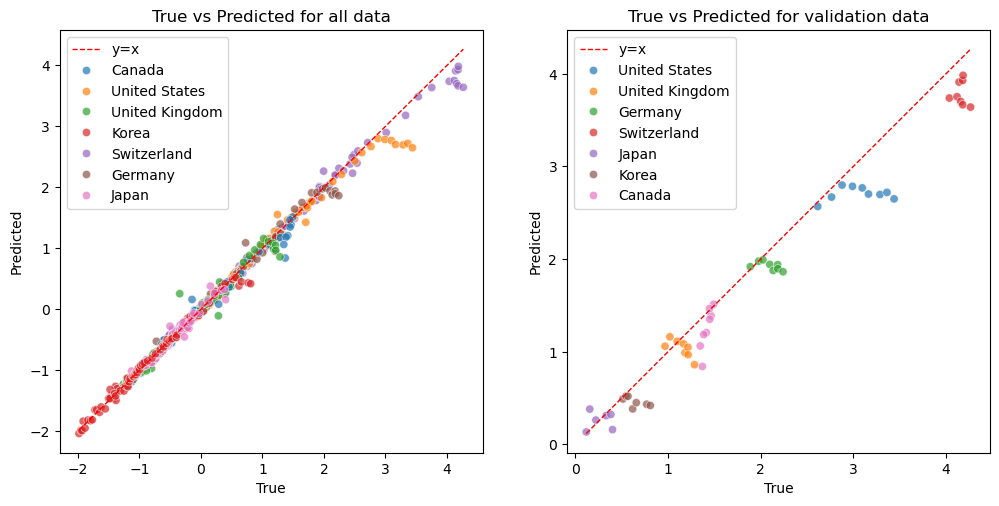

In [194]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame(dict({'date': X_valid['date'], 'country': country_valid, 'y_true': y_valid}, **y_pred_valid))
y_pred_train_country = pd.DataFrame(dict({'date': X_train['date'], 'country': country_train, 'y_true': y_train}, **y_pred_train))

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_true"] + [f'y_pred_{model}' for model in models],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(df, true_key="y_true", pred_key="y_pred"):
    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    plt.plot([np.min(predictions[true_key]), np.max(predictions[true_key])], [np.min(predictions[true_key]), np.max(predictions[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    plt.plot([np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], [np.min(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[true_key])], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

for model in models:
    print(f'{model} :')
    plot_predictions_against_true(predictions, true_key="y_true", pred_key=f"y_pred_{model}")

In [195]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country_with_confidence(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country_with_confidence, selected_country=dropdown)

# Calculate Mean Squared Error
for model in models:
    print(f"{model} : Training  ME: {mean_squared_error(y_train, y_pred_train[f'y_pred_{model}']):.4f}, Validation MSE: {mean_squared_error(y_valid, y_pred_valid[f'y_pred_{model}']):.4f}")

interactive(children=(Dropdown(description='Country:', options=('Canada', 'United States', 'United Kingdom', '…

ols : Training  ME: 0.0051, Validation MSE: 0.0865


In [196]:
# OLD

import shap

PLOT_SHAP = False

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
